In [2]:
# import system libs
import os
import time
import pathlib
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2, l2

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [4]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 321M/325M [00:10<00:00, 40.3MB/s]
100% 325M/325M [00:10<00:00, 31.8MB/s]


In [7]:
# Unzipping Files
!unzip -q 'skin-cancer-malignant-vs-benign.zip'

replace data/test/benign/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/test/benign/10.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [9]:
# Generate data paths with labels
train_data_dir = '/content/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [10]:
# Generate data paths with labels
test_data_dir = '/content/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [11]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1/255.,horizontal_flip=True, vertical_flip=True, rotation_range=40)
ts_gen = ImageDataGenerator(rescale=1/255.)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels',
                                       target_size= img_size, class_mode= 'categorical',
                                       color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                      target_size= img_size, class_mode= 'categorical',
                                      color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


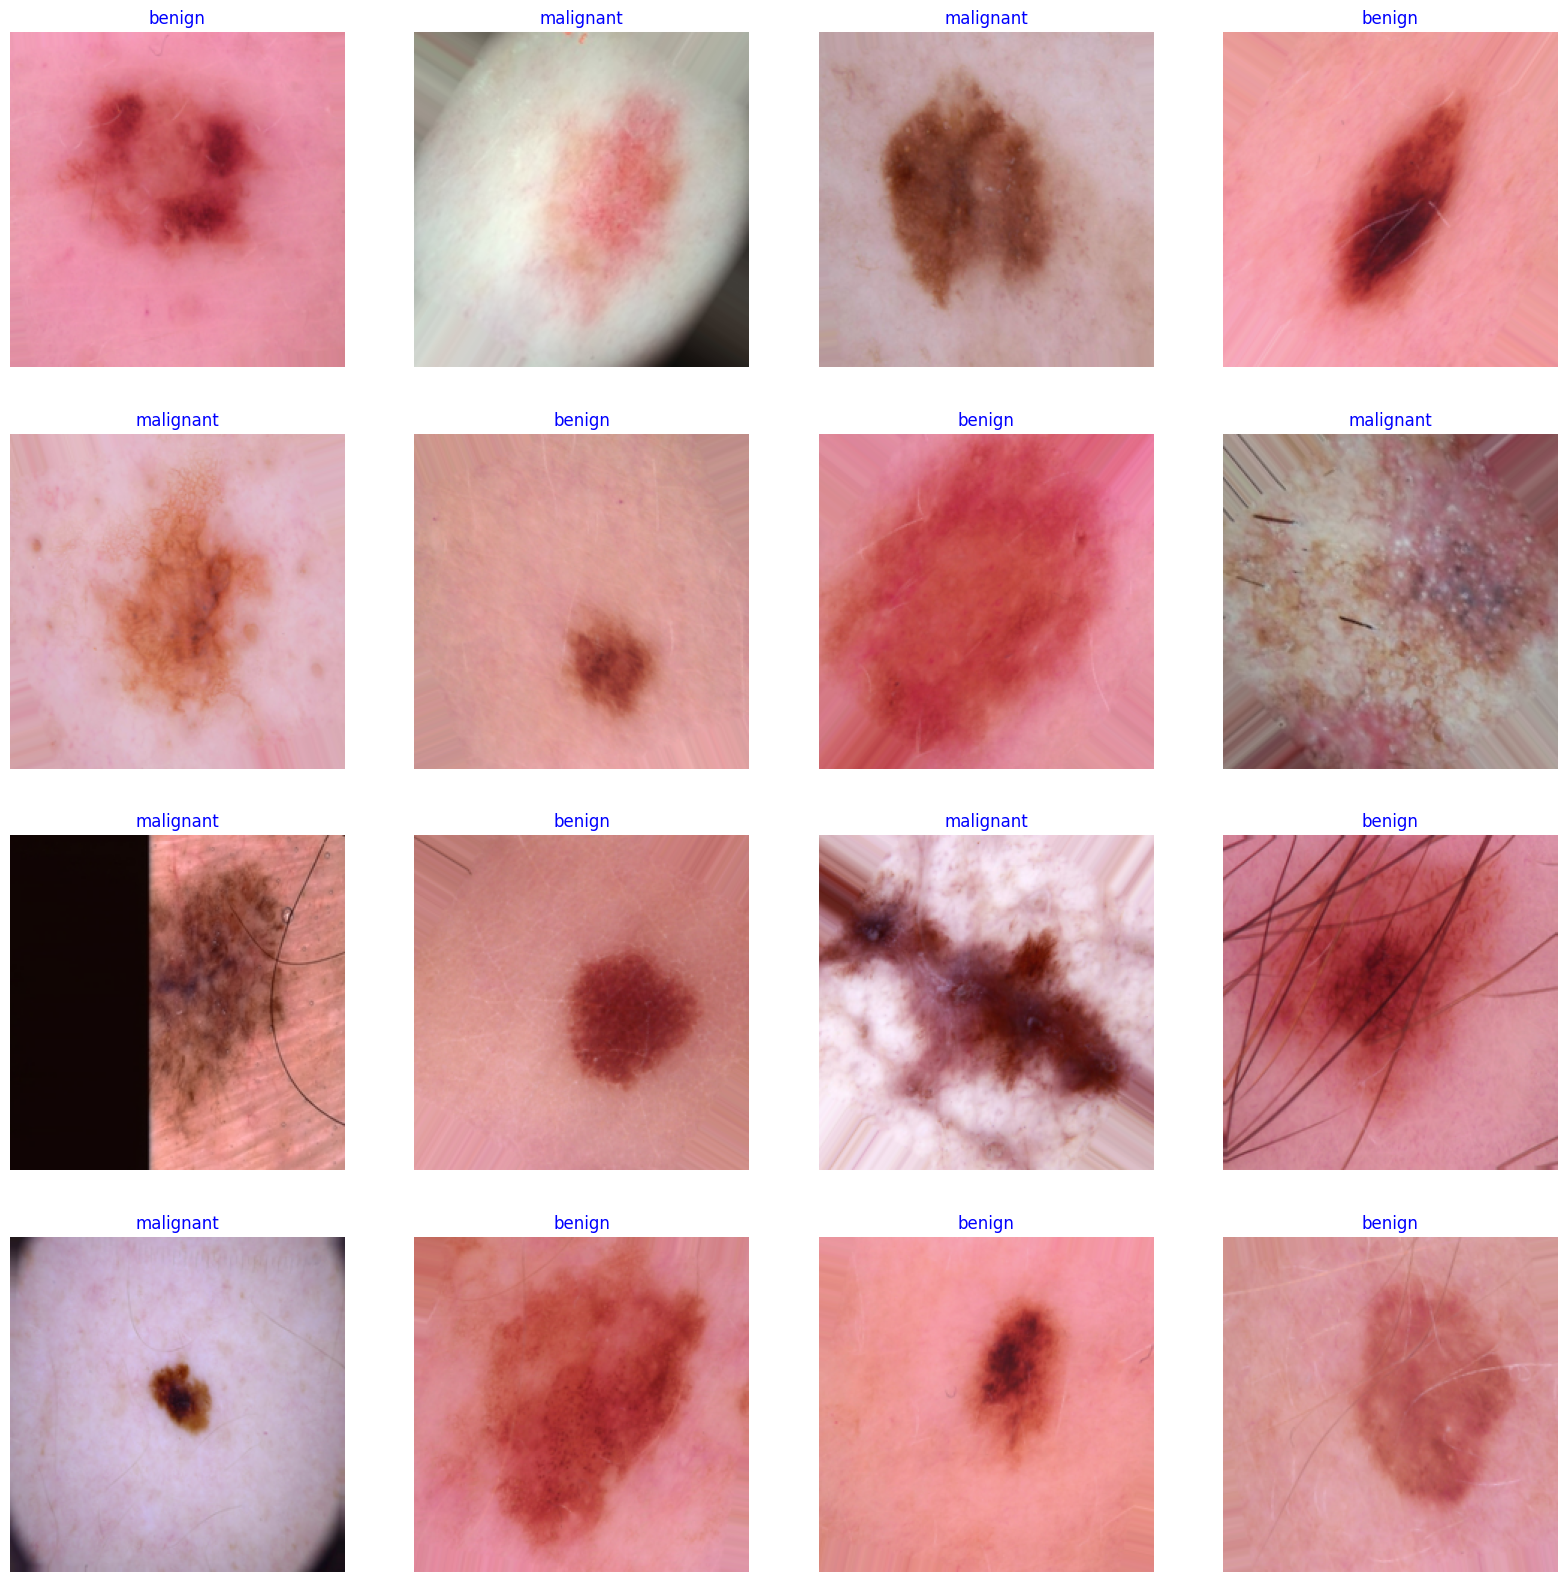

In [12]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [17]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu' ,input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Block 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layer 1
model.add(Flatten())
model.add(Dense(512,activation='relu', kernel_regularizer=l1_l2(0.01), activity_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 111, 111, 32)      0         
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 conv2d_16 (Conv2D)          (None, 107, 107, 64)     

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
history1 = model.fit(train_gen,
                     validation_data = test_gen,
                     batch_size = 64,
                     epochs = 50)

Epoch 1/50
42/42 [==============================] - 48s 1s/step - loss: 268.2218 - accuracy: 0.6837 - val_loss: 40.7198 - val_accuracy: 0.4545
Epoch 2/50
42/42 [==============================] - 44s 1s/step - loss: 23.9443 - accuracy: 0.7626 - val_loss: 18.4732 - val_accuracy: 0.4545
Epoch 3/50
42/42 [==============================] - 44s 1s/step - loss: 17.8309 - accuracy: 0.7660 - val_loss: 17.7395 - val_accuracy: 0.4591
Epoch 4/50
42/42 [==============================] - 45s 1s/step - loss: 17.3204 - accuracy: 0.7846 - val_loss: 17.3990 - val_accuracy: 0.6515
Epoch 5/50
42/42 [==============================] - 43s 1s/step - loss: 17.1724 - accuracy: 0.7808 - val_loss: 17.1424 - val_accuracy: 0.6530
Epoch 6/50
42/42 [==============================] - 44s 1s/step - loss: 17.0064 - accuracy: 0.7869 - val_loss: 16.9791 - val_accuracy: 0.6742
Epoch 7/50
42/42 [==============================] - 44s 1s/step - loss: 16.8114 - accuracy: 0.8024 - val_loss: 16.9355 - val_accuracy: 0.6788
Epoch

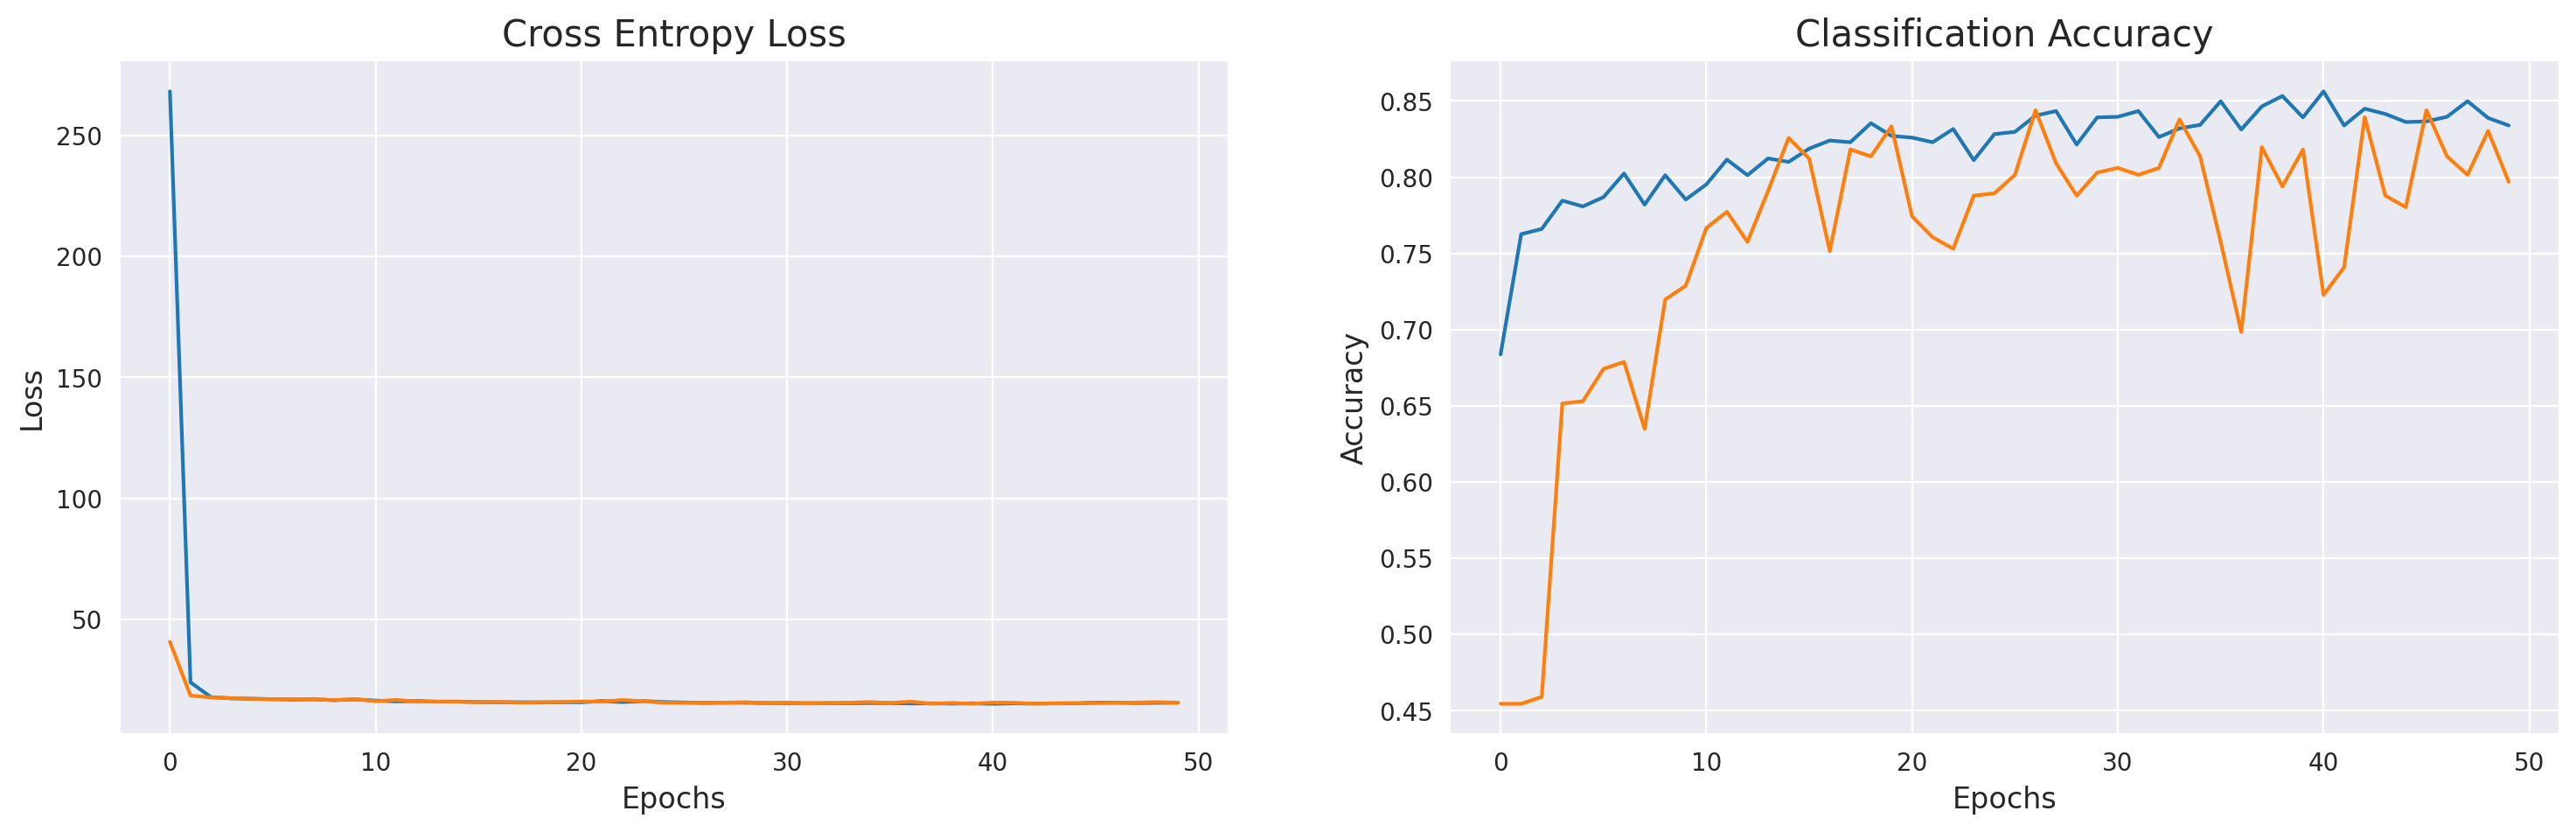

In [20]:

# plots for accuracy and Loss with epochs

error = pd.DataFrame(history1.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [21]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_gen)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(test_gen)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

42/42 [==============================] - 38s 900ms/step - loss: 15.5732 - accuracy: 0.7880
The accuracy of the model for training data is: 78.8016676902771
The Loss of the model for training data is: 15.573214530944824
11/11 [==============================] - 2s 177ms/step - loss: 15.5650 - accuracy: 0.7970
The accuracy of the model for validation data is: 79.69697117805481
The Loss of the model for validation data is: 15.565003395080566


In [22]:
# prediction
result = model.predict(test_gen)

y_pred = np.argmax(result, axis = 1)

y_true = test_gen.labels

# Evaluvate
loss,acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

11/11 [==============================] - 2s 180ms/step - loss: 15.5650 - accuracy: 0.7970
The accuracy of the model for testing data is: 79.69697117805481
The Loss of the model for testing data is: 15.565003395080566


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79       360
           1       0.72      0.90      0.80       300

    accuracy                           0.80       660
   macro avg       0.81      0.81      0.80       660
weighted avg       0.82      0.80      0.80       660

